In [55]:
import pandas as pd
import numpy as np
from seaborn import heatmap
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import label_binarize

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
X_train = pd.read_csv('./data/processed_train.csv').set_index('id').drop(columns=['Unnamed: 0'])
y_train = pd.read_csv('./data/train_pred.csv').set_index('id').drop(columns=['Unnamed: 0'])
binary_y = label_binarize(y_train['y'], classes=['functional', 'non functional', 'functional needs repair'])

id
0        non functional
1            functional
2            functional
3            functional
4        non functional
              ...      
96772    non functional
96773    non functional
96774    non functional
96775    non functional
96776    non functional
Name: y, Length: 96777, dtype: object


array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

# Grid Search

In [15]:
def grid_search(model, grid, X_train,y_train, cv=None):
    gs = GridSearchCV(estimator=model, param_grid=grid, cv=cv)
    gs.fit(X_train, y_train)
    return gs.best_params_


def randomized_search(model, params, X_train, Y_train):
    gs_rand = RandomizedSearchCV(model, params)
    gs_rand.fit(X_train, y_train)
    return gs.best_params_


### Classifier Evaluation

In [71]:
def evaluate_classifier(model, X, y_actual):
    cross_val_mean = np.mean(cross_val_score(model, X, y_actual))
    print(f"Average cross val score: {cross_val_mean}")
    
    model.fit(X_train, y_actual)
    y_pred = model.predict(X)
    print(cross_val_mean)
  
    try:
        cm = confusion_matrix(y_actual.argmax(axis=1), y_pred.argmax(axis=1))
    except:
        cm = confusion_matrix(y_actual, y_pred)
  
    heatmap(cm, xticklabels=['functional', 'non functional', 'needs repair']
                  , yticklabels=['functional', 'non functional', 'needs repair']
                  ,annot=True
                  ,cmap='viridis'), 
    print(cm)
    
  
    #plot_roc_curve(model, X, y_actual['y'])

# Dummy Model
For my dummy model, I'll be predicting 'function'. Since each class is distributed equally, the accuracy for this dummy model will be the same for always predicting 'non functional' or 'functional needs repair'


In [66]:
y_pred = ['functional']*len(y_train)
accuracy_score(y_train['y'], y_pred)

0.3333333333333333

# Decision Tree

### Decision Tree With Default Parameters

The default model has a high accuracy but it could be overfitting

Average cross val score: 0.7057053874623375
Accuracy: 0.8463271231800944
[[28451  1562  2246]
 [ 4200 26955  1104]
 [ 2931   403 28925]]


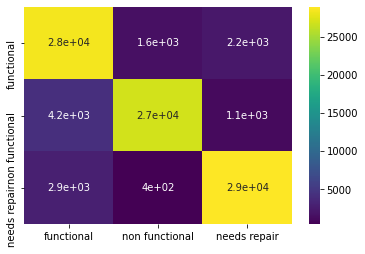

In [59]:
tree_clf_baseline = DecisionTreeClassifier(random_state=666)
evaluate_classifier(tree_clf_baseline, X_train, binary_y)


### Parameter Tuning

To handle overfitting we'll modify:


*   minimum samples per leaf node
*   Max number of leaf nodes
*   Minimum impurity decrease



In [60]:
num_samples = len(X_train)

grid = {'min_samples_leaf' : [1,.15,.5,.03,.25]
      ,'max_leaf_nodes' : [4,5,40]
      ,'min_impurity_decrease' : [.15,.25,.5,.33]
      ,'criterion': ['gini', 'entropy']}


tuning_model = DecisionTreeClassifier(random_state=666)
best_params = grid_search(tuning_model, grid, X_train, y_train)
best_params

{'criterion': 'entropy',
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.15,
 'min_samples_leaf': 1}

### Grid searched Decision tree preformed worse than the dummy classifier

Average cross val score: 0.2013984044966602
Accuracy: 0.0
[[32259     0     0]
 [32259     0     0]
 [32259     0     0]]


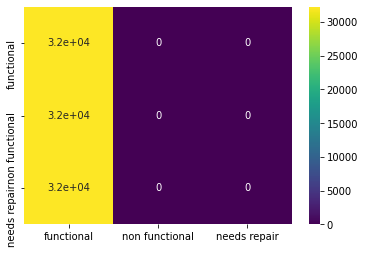

In [62]:
grid_search_decision_tree = DecisionTreeClassifier(random_state=666, **best_params)
evaluate_classifier(grid_search_decision_tree, X_train, binary_y)


## Gradient Boosting 

Average cross val score: 0.762495429556066
0.762495429556066
[[22926  5310  4023]
 [ 3090 27529  1640]
 [ 5661  3097 23501]]


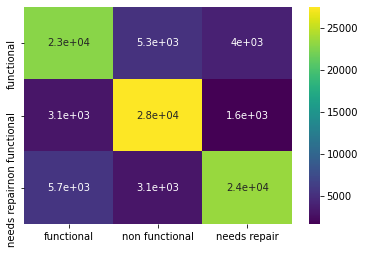

In [72]:
gbc = GradientBoostingClassifier(random_state=666)
evaluate_classifier(gbc, X_train, y_train['y'])

## AdaBoost Classifier

Average cross val score: 0.762495429556066
0.762495429556066
[[22926  5310  4023]
 [ 3090 27529  1640]
 [ 5661  3097 23501]]


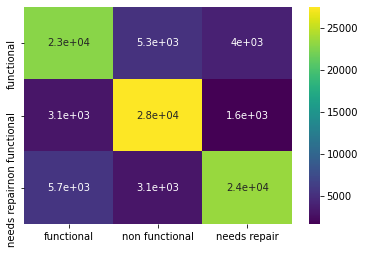

In [75]:
ada_boost = AdaBoostClassifier(random_state=666)
evaluate_classifier(gbc, X_train,y_train['y'])